# Camera Calibration and Distorsion Correction

In [1]:
import math
from decimal import Decimal
import numpy as np
import cv2
import glob
from tracker import tracker
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
folder_path = './camera_cal/'
images = glob.glob('./camera_cal/calibration*.jpg')

def camera_calibration(gray_image_data):
    images = np.copy(gray_image_data)
    
    # Step through the list and search for chessboard corners
    for idx, fname in tqdm(enumerate(images)):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            '''
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (9,6), corners, ret)
            write_name = './camera_cal/corners_found'+str(idx)+'.jpg'
            cv2.imwrite(write_name, img)
            #cv2.imshow('img', img)
            #cv2.waitKey(500)
            '''
    # Do camera calibration given object points and image points
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
            
    return ret, mtx, dist, rvecs, tvecs

ret, mtx, dist, rvecs, tvecs = camera_calibration(images)

20it [00:04,  4.26it/s]


In [3]:
def distortion_correction(image_datum, mtx, dist):
    image = np.copy(image_datum)

    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    return dst

# Define a funcgion for plotting multiple images
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            #fig.savefig('output_images/{0}'.format(titles[i]))
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])
            #fig.savefig('output_images/{0}'.format(titles[i]))
    fig.tight_layout()

In [ ]:
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
#print(dist_pickle)
pickle.dump( dist_pickle, open( "./camera_cal/calibration_ pickle.p", "wb" ) )

### Distorted Images

6it [00:00, 66.24it/s]


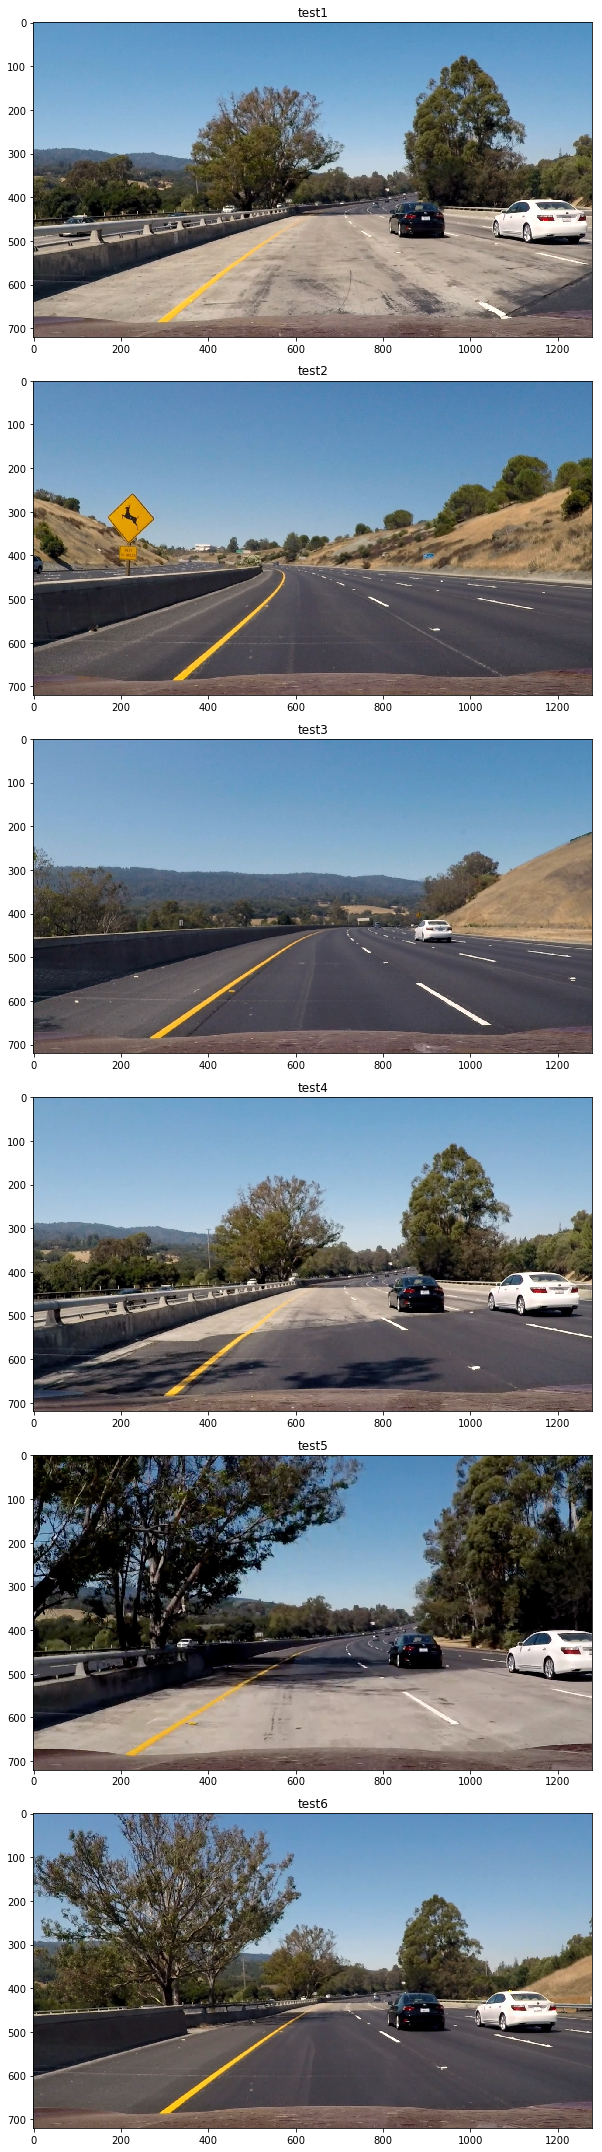

In [4]:
# Make a list of calibration images
folder_path = './test_images/'
images = glob.glob(folder_path+'test*.jpg')

original_imgs = []

# Step through the list and search for chessboard corners
for idx, fname in tqdm(enumerate(images)):
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    original_imgs.append(img)
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

fig = plt.figure(figsize=(30,30))
visualize(fig, 6, 1, original_imgs, ['test1', 'test2', 'test3', 'test4', 'test5', 'test6'])

### Corrected Images

6it [00:00, 22.77it/s]


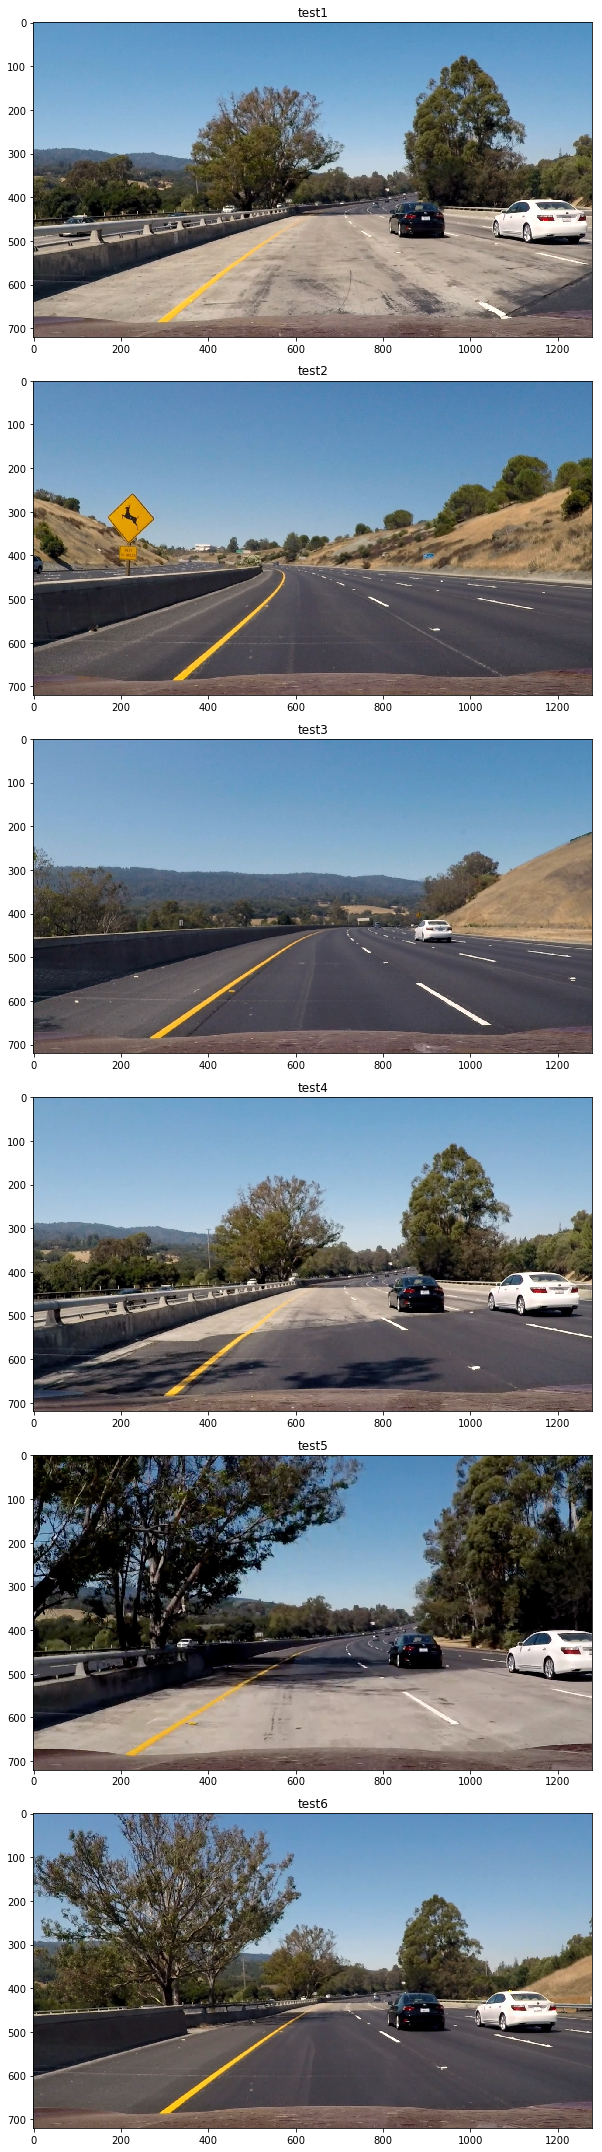

In [5]:
# Make a list of calibration images
folder_path = './test_images/'
images = glob.glob(folder_path+'test*.jpg')

distortion_corrected_imgs = []

# Step through the list and search for chessboard corners
for idx, fname in tqdm(enumerate(images)):
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    undistortion_img = distortion_correction(img, mtx, dist)
    distortion_corrected_imgs.append(img)
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

fig = plt.figure(figsize=(30,30))
visualize(fig, 6, 1, distortion_corrected_imgs, ['test1', 'test2', 'test3', 'test4', 'test5', 'test6'])

In [6]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices_outer, vertices_inner):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    # print("mask: ", mask.shape)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
        # print("True")
    else:
        ignore_mask_color = 255
        # print("False")
    
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, [vertices_outer], ignore_mask_color)
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    cv2.fillPoly(masked_image, [vertices_inner], 0)
    
    return masked_image

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def normaliseColourImages(image):
    img = np.copy(image.astype(np.float32))
    img = cv2.normalize(img, dst=img, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return img

## Enhance Contrast using histogram equalization
def enhanceContrastOfImage(img):
    #return cv2.equalizeHist(img)

    yuv_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    yuv_img[:,:,0] = cv2.equalizeHist(np.asarray(yuv_img[:,:,0], np.uint8))
    return cv2.cvtColor(yuv_img, cv2.COLOR_YUV2RGB)

### Sharpen Image

6it [00:00, 176.18it/s]


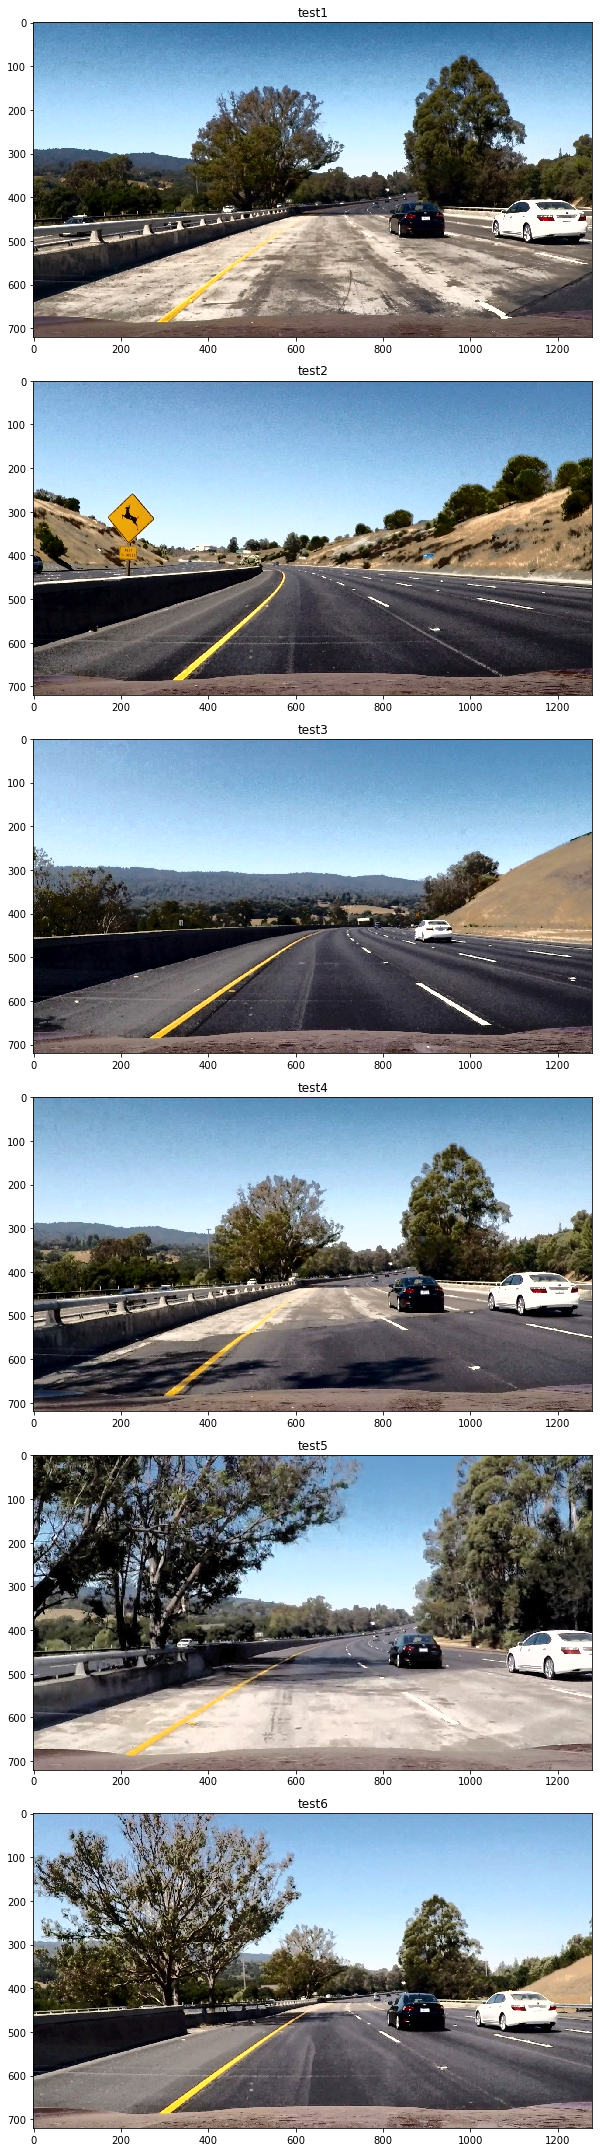

In [7]:
'''
enhanced_img = enhanceContrastOfImage(image)
plt.figure(figsize=(13,13))
plt.imshow(enhanced_img, cmap='gray')
print("blur_gray shape:", enhanced_img.shape)
'''
enhanced_imgs = []

# Step through the list and search for undistorted images
for idx, fname in tqdm(enumerate(distortion_corrected_imgs)):
    img = enhanceContrastOfImage(fname)
    enhanced_imgs.append(img)
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

fig = plt.figure(figsize=(30,30))
visualize(fig, 6, 1, enhanced_imgs, ['test1', 'test2', 'test3', 'test4', 'test5', 'test6'])

### Gray Scale

### Mask Configuration

In [8]:
# Mask
imshape = np.shape(original_imgs[0])

bottom_mask = 490
middle_mask = 80
width_center = imshape[1]*0.5
height_center = imshape[0]*0.6
height_bottom = imshape[0]*0.07

vertices_1 = np.array([(width_center-bottom_mask,imshape[0]-height_bottom),
                        (width_center-middle_mask, height_center),
                        (width_center+middle_mask, height_center),
                        (width_center+bottom_mask,imshape[0]-height_bottom)], dtype=np.int32)

inner_bottom_mask = 230
inner_middle_mask = 20
inner_height_center = imshape[0]*0.7
inner_height_bottom = imshape[0]*0.07

vertices_2 = np.array([(width_center-inner_bottom_mask,imshape[0]-height_bottom),
                        (width_center-inner_middle_mask, inner_height_center),
                        (width_center+inner_middle_mask, inner_height_center),
                        (width_center+inner_bottom_mask,imshape[0]-height_bottom)], dtype=np.int32)

# Image Processing

In [9]:
# Appies Colour threshold
def colour_threshold(img, hthresh=(80,102), lthresh=(230,255), sthresh=(200, 255), vthresh=(220, 255), bthresh=(155,200)):

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    h_channel = hls[:,:,0]
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= hthresh[0]) & (h_channel <= hthresh[1])] = 1
    
    l_channel = hls[:,:,1]
    #l_binary = np.ones_like(l_channel)
    #l_binary[(l_channel >= lthresh[0]) & (l_channel <= lthresh[1])] = 0
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= lthresh[0]) & (l_channel <= lthresh[1])] = 1
    
    s_channel = hls[:,:,2]
    s_binary = np.ones_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 0
    #s_binary = np.zeros_like(s_channel)
    #s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1

    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= vthresh[0]) & (v_channel <= vthresh[1])] = 1

    Lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    b_channel = Lab[:,:,2]
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= bthresh[0]) & (b_channel <= bthresh[1])] = 1

    '''
    output = np.zeros_like(s_channel)
    output[h_binary == 1] = 255
    #write_name = './test_images/binary_h' + str(idx+1) + '.jpg'
    #cv2.imwrite(write_name, output)

    output = np.zeros_like(s_channel)
    output[s_binary == 1] = 255
    #write_name = './test_images/binary_s' + str(idx+1) + '.jpg'
    #cv2.imwrite(write_name, output)

    output = np.zeros_like(s_channel)
    output[v_binary == 1] = 255
    #write_name = './test_images/binary_v' + str(idx+1) + '.jpg'
    #cv2.imwrite(write_name, output)
    '''
    
    #output = np.zeros_like(s_channel)
    #output[(h_binary==1) | (s_binary == 1) | (l_binary == 1) | (v_binary == 1) | (b_binary==1)] = 1
    #output[(l_binary==1) | (b_binary==1)]=1
    return h_binary, l_binary, s_binary, v_binary, b_binary

def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    #output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width)):min(int(center+width),img_ref.shape[1])] = 1
    return output

### Colour Threshold

In [10]:
colour_threshold_imgs = []
#train_label = []
# Step through the list and search for chessboard corners
for idx, fname in tqdm(enumerate(enhanced_imgs)):
    h_binary, l_binary, s_binary, v_binary, b_binary = colour_threshold(fname, hthresh=(20,50), lthresh=(150,255), sthresh=(10, 180), vthresh=(240, 255), bthresh=(90,115))
    colour_threshold_imgs.append([h_binary, l_binary, s_binary, v_binary, b_binary])
    #train_label.append(round(Decimal(np.mean(l_binary[440:, :])), 4))

6it [00:00, 45.00it/s]


### Test Image 1

In [ ]:
print(np.mean(colour_threshold_imgs[0]))
print(np.std(colour_threshold_imgs[0]))

In [ ]:
fig = plt.figure(figsize=(30,30))
visualize(fig, 5, 1, colour_threshold_imgs[0], ['h_binary', 'l_binary', 's_binary', 'v_binary', 'b_binary'])

In [ ]:
# h_binary & s_binary
hb_thresh = np.zeros_like(colour_threshold_imgs[0][0])
hb_thresh[( (colour_threshold_imgs[0][0] == 1) | (colour_threshold_imgs[0][4] == 1) ) ] = 1
plt.figure(figsize=(13, 13))
plt.title('h | b')
plt.imshow(hb_thresh*255, cmap='gray')

In [ ]:
# s_binary & v_binary
sv_thresh = np.zeros_like(colour_threshold_imgs[0][0])
sv_thresh[( colour_threshold_imgs[0][2]==1  ) & ( colour_threshold_imgs[0][3]==1 ) ] = 1
plt.figure(figsize=(13, 13))
plt.title('s & v')
plt.imshow(sv_thresh*255, cmap='gray')

In [ ]:
# (h_binary & s_binary) | (s_binary & v_binary)
hbsv_thresh = np.zeros_like(colour_threshold_imgs[0][0])
hbsv_thresh[(hb_thresh == 1) | (sv_thresh == 1)] = 1
plt.figure(figsize=(13, 13))
plt.title('hbsv')
plt.imshow(hbsv_thresh*255, cmap='gray')

In [ ]:
# ( (h_binary & s_binary) | (s_binary & v_binary) ) & l_binary
hbsvl_thresh = np.zeros_like(colour_threshold_imgs[0][0])
hbsvl_thresh[(hbsv_thresh == 1) & (colour_threshold_imgs[0][1] == 1)] = 1
plt.figure(figsize=(13,13))
plt.imshow(hbsvl_thresh*255, cmap='gray')

In [ ]:
masked_img1 = region_of_interest(hbsvl_thresh, vertices_1, vertices_2)
plt.figure(figsize=(13,13))
plt.imshow(masked_img1, cmap='gray')

print("masked_edges shape: ", masked_img1.shape)

### Test Image 2

In [ ]:
print(np.mean(colour_threshold_imgs[1]))
print(np.std(colour_threshold_imgs[1]))

In [ ]:
fig = plt.figure(figsize=(30,30))
visualize(fig, 5, 1, colour_threshold_imgs[1], ['h_binary', 'l_binary', 's_binary', 'v_binary', 'b_binary'])

In [ ]:
# h_binary & s_binary
hb_thresh = np.zeros_like(colour_threshold_imgs[0][0])
hb_thresh[( (colour_threshold_imgs[1][0] == 1) | (colour_threshold_imgs[1][4] == 1) ) ] = 1
plt.figure(figsize=(13, 13))
plt.title('h | b')
plt.imshow(hb_thresh*255, cmap='gray')

In [ ]:
# s_binary & v_binary
sv_thresh = np.zeros_like(colour_threshold_imgs[0][0])
sv_thresh[( colour_threshold_imgs[1][2]==1  ) & ( colour_threshold_imgs[1][3]==1 ) ] = 1
plt.figure(figsize=(13, 13))
plt.title('s & v')
plt.imshow(sv_thresh*255, cmap='gray')

In [ ]:
# (h_binary & s_binary) | (s_binary & v_binary)
hbsv_thresh = np.zeros_like(colour_threshold_imgs[0][0])
hbsv_thresh[(hb_thresh == 1) | (sv_thresh == 1)] = 1
plt.figure(figsize=(13, 13))
plt.title('hbsv')
plt.imshow(hbsv_thresh*255, cmap='gray')

In [ ]:
# ( (h_binary & s_binary) | (s_binary & v_binary) ) & l_binary
hbsvl_thresh = np.zeros_like(colour_threshold_imgs[0][0])
hbsvl_thresh[(hbsv_thresh == 1) & (colour_threshold_imgs[1][1] == 1)] = 1
plt.figure(figsize=(13,13))
plt.imshow(hbsvl_thresh*255, cmap='gray')

In [ ]:
masked_img2 = region_of_interest(hbsvl_thresh, vertices_1, vertices_2)
plt.figure(figsize=(13,13))
plt.imshow(masked_img2, cmap='gray')

print("masked_edges shape: ", masked_img2.shape)

### Test Image 3

In [ ]:
print(np.mean(colour_threshold_imgs[2]))
print(np.std(colour_threshold_imgs[2]))

In [ ]:
fig = plt.figure(figsize=(30,30))
visualize(fig, 5, 1, colour_threshold_imgs[2], ['h_binary', 'l_binary', 's_binary', 'v_binary', 'b_binary'])

In [ ]:
# h_binary & s_binary
hb_thresh = np.zeros_like(colour_threshold_imgs[0][0])
hb_thresh[( (colour_threshold_imgs[2][0] == 1) | (colour_threshold_imgs[2][4] == 1) ) ] = 1
plt.figure(figsize=(13, 13))
plt.title('h | b')
plt.imshow(hb_thresh*255, cmap='gray')

In [ ]:
# s_binary & v_binary
sv_thresh = np.zeros_like(colour_threshold_imgs[0][0])
sv_thresh[( colour_threshold_imgs[2][2]==1  ) & ( colour_threshold_imgs[2][3]==1 ) ] = 1
plt.figure(figsize=(13, 13))
plt.title('s & v')
plt.imshow(sv_thresh*255, cmap='gray')

In [ ]:
# (h_binary & s_binary) | (s_binary & v_binary)
hbsv_thresh = np.zeros_like(colour_threshold_imgs[0][0])
hbsv_thresh[(hb_thresh == 1) | (sv_thresh == 1)] = 1
plt.figure(figsize=(13, 13))
plt.title('hbsv')
plt.imshow(hbsv_thresh*255, cmap='gray')

In [ ]:
# ( (h_binary & s_binary) | (s_binary & v_binary) ) & l_binary
hbsvl_thresh = np.zeros_like(colour_threshold_imgs[0][0])
hbsvl_thresh[(hbsv_thresh == 1) & (colour_threshold_imgs[2][1] == 1)] = 1
plt.figure(figsize=(13,13))
plt.imshow(hbsvl_thresh*255, cmap='gray')

In [ ]:
masked_img3 = region_of_interest(hbsvl_thresh, vertices_1, vertices_2)
plt.figure(figsize=(13,13))
plt.imshow(masked_img3, cmap='gray')

print("masked_edges shape: ", masked_img3.shape)

### Test Image 4

In [ ]:
print(np.mean(colour_threshold_imgs[3]))
print(np.std(colour_threshold_imgs[3]))

In [ ]:
fig = plt.figure(figsize=(30,30))
visualize(fig, 5, 1, colour_threshold_imgs[3], ['h_binary', 'l_binary', 's_binary', 'v_binary', 'b_binary'])

In [ ]:
# h_binary & s_binary
hb_thresh = np.zeros_like(colour_threshold_imgs[0][0])
hb_thresh[( (colour_threshold_imgs[3][0] == 1) | (colour_threshold_imgs[3][4] == 1) ) ] = 1
plt.figure(figsize=(13, 13))
plt.title('h | b')
plt.imshow(hb_thresh*255, cmap='gray')

In [ ]:
# s_binary & v_binary
sv_thresh = np.zeros_like(colour_threshold_imgs[0][0])
sv_thresh[( colour_threshold_imgs[3][2]==1  ) & ( colour_threshold_imgs[3][3]==1 ) ] = 1
plt.figure(figsize=(13, 13))
plt.title('s & v')
plt.imshow(sv_thresh*255, cmap='gray')

In [ ]:
# (h_binary & s_binary) | (s_binary & v_binary)
hbsv_thresh = np.zeros_like(colour_threshold_imgs[0][0])
hbsv_thresh[(hb_thresh == 1) | (sv_thresh == 1)] = 1
plt.figure(figsize=(13, 13))
plt.title('hbsv')
plt.imshow(hbsv_thresh*255, cmap='gray')

In [ ]:
# ( (h_binary & s_binary) | (s_binary & v_binary) ) & l_binary
hbsvl_thresh = np.zeros_like(colour_threshold_imgs[0][0])
hbsvl_thresh[(hbsv_thresh == 1) & (colour_threshold_imgs[3][1] == 1)] = 1
plt.figure(figsize=(13,13))
plt.imshow(hbsvl_thresh*255, cmap='gray')

In [ ]:
masked_img4 = region_of_interest(hbsvl_thresh, vertices_1, vertices_2)
plt.figure(figsize=(13,13))
plt.imshow(masked_img4, cmap='gray')

print("masked_edges shape: ", masked_img4.shape)

### Test Image 5

In [ ]:
print(np.mean(colour_threshold_imgs[4]))
print(np.std(colour_threshold_imgs[4]))

In [ ]:
fig = plt.figure(figsize=(30,30))
visualize(fig, 5, 1, colour_threshold_imgs[4], ['h_binary', 'l_binary', 's_binary', 'v_binary', 'b_binary'])

In [ ]:
# h_binary & s_binary
hb_thresh = np.zeros_like(colour_threshold_imgs[0][0])
hb_thresh[( (colour_threshold_imgs[4][0] == 1) | (colour_threshold_imgs[4][4] == 1) ) ] = 1
plt.figure(figsize=(13, 13))
plt.title('h | b')
plt.imshow(hb_thresh*255, cmap='gray')

In [ ]:
# s_binary & v_binary
sv_thresh = np.zeros_like(colour_threshold_imgs[0][0])
sv_thresh[( colour_threshold_imgs[4][2]==1  ) & ( colour_threshold_imgs[4][3]==1 ) ] = 1
plt.figure(figsize=(13, 13))
plt.title('s & v')
plt.imshow(sv_thresh*255, cmap='gray')

In [ ]:
# (h_binary & s_binary) | (s_binary & v_binary)
hbsv_thresh = np.zeros_like(colour_threshold_imgs[0][0])
hbsv_thresh[(hb_thresh == 1) | (sv_thresh == 1)] = 1
plt.figure(figsize=(13, 13))
plt.title('hbsv')
plt.imshow(hbsv_thresh*255, cmap='gray')

In [ ]:
# ( (h_binary & s_binary) | (s_binary & v_binary) ) & l_binary
hbsvl_thresh = np.zeros_like(colour_threshold_imgs[0][0])
hbsvl_thresh[(hbsv_thresh == 1) & (colour_threshold_imgs[4][1] == 1)] = 1
plt.figure(figsize=(13,13))
plt.imshow(hbsvl_thresh*255, cmap='gray')

In [ ]:
masked_img5 = region_of_interest(hbsvl_thresh, vertices_1, vertices_2)
plt.figure(figsize=(13,13))
plt.imshow(masked_img5, cmap='gray')

print("masked_edges shape: ", masked_img5.shape)

### Test Image 6

In [30]:
print(np.mean(colour_threshold_imgs[5]))
print(np.std(colour_threshold_imgs[5]))

0.240212456597
0.427212397167


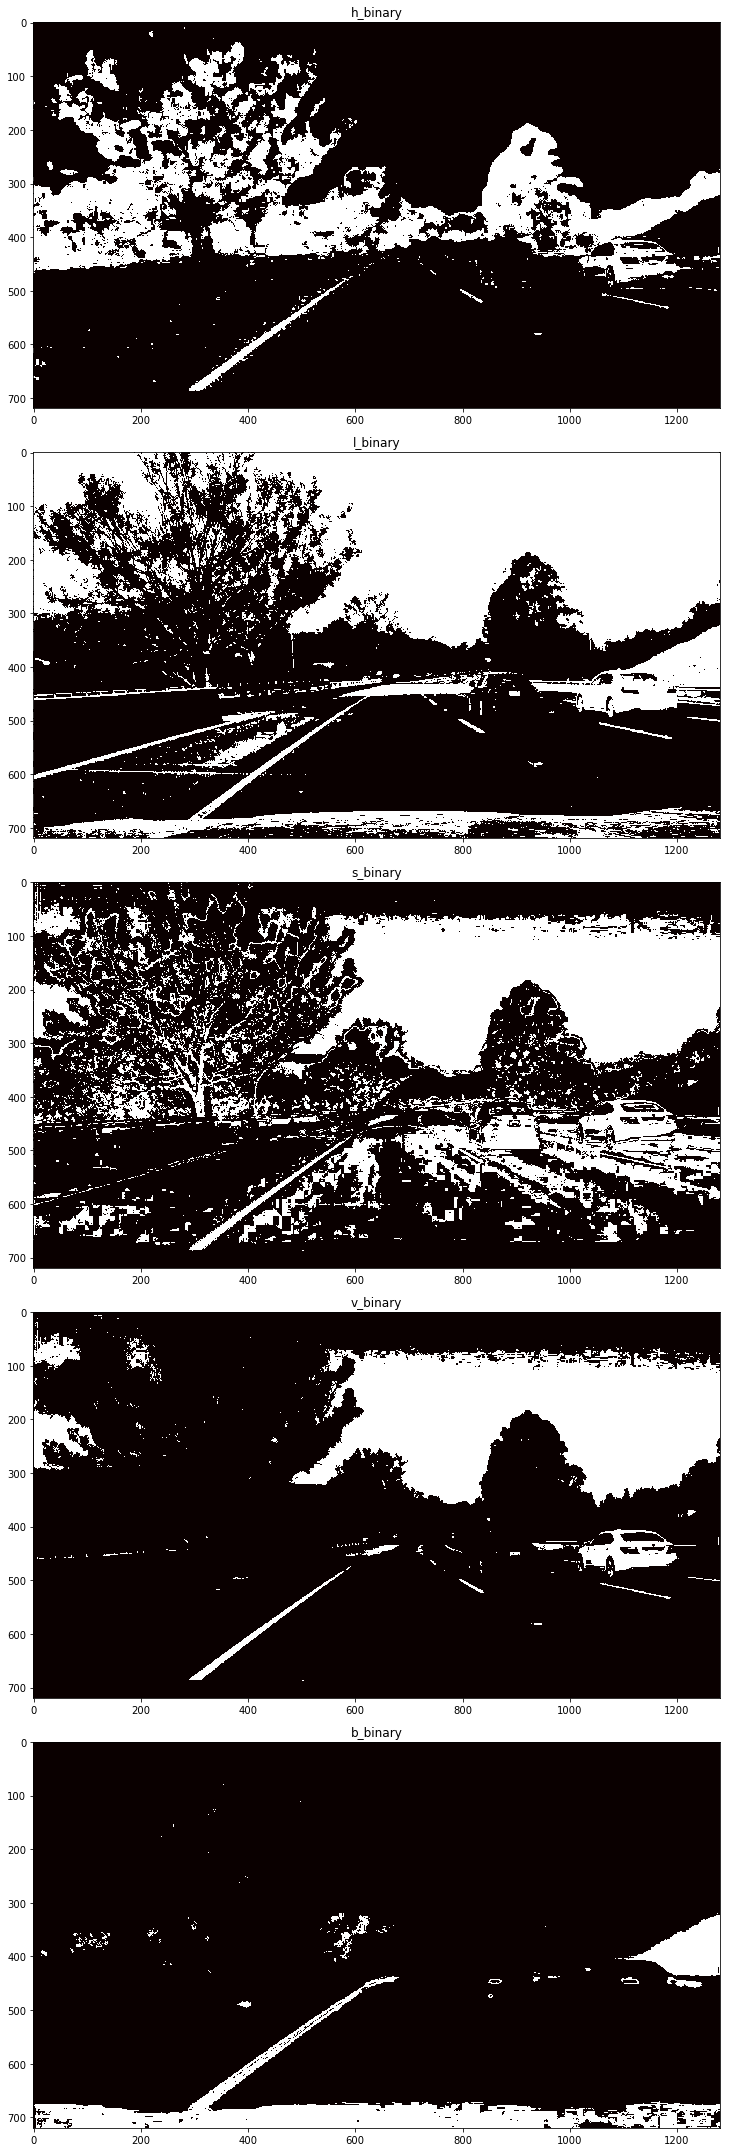

In [31]:
fig = plt.figure(figsize=(30,30))
visualize(fig, 5, 1, colour_threshold_imgs[5], ['h_binary', 'l_binary', 's_binary', 'v_binary', 'b_binary'])

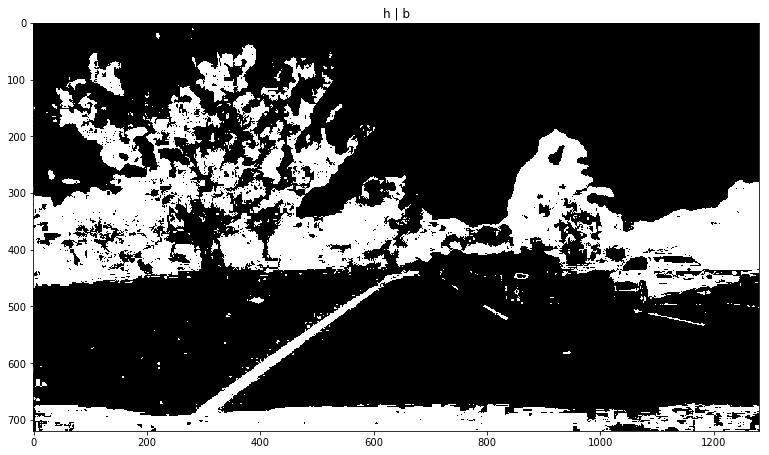

In [32]:
# h_binary & s_binary
hb_thresh = np.zeros_like(colour_threshold_imgs[0][0])
hb_thresh[( (colour_threshold_imgs[5][0] == 1) | (colour_threshold_imgs[5][4] == 1) ) ] = 1
plt.figure(figsize=(13, 13))
plt.title('h | b')
plt.imshow(hb_thresh*255, cmap='gray')

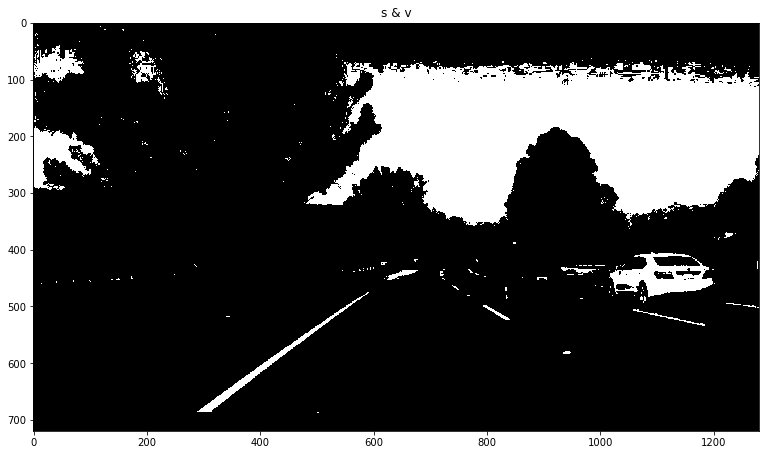

In [33]:
# s_binary & v_binary
sv_thresh = np.zeros_like(colour_threshold_imgs[0][0])
sv_thresh[( colour_threshold_imgs[5][2]==1  ) & ( colour_threshold_imgs[5][3]==1 ) ] = 1
plt.figure(figsize=(13, 13))
plt.title('s & v')
plt.imshow(sv_thresh*255, cmap='gray')

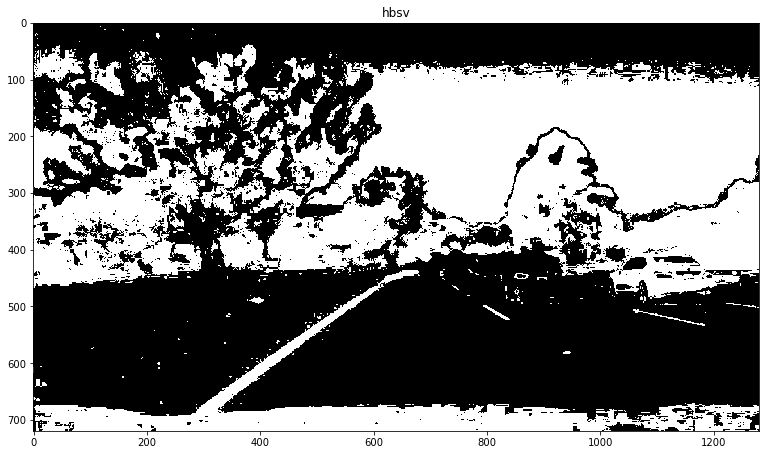

In [34]:
# (h_binary & s_binary) | (s_binary & v_binary)
hbsv_thresh = np.zeros_like(colour_threshold_imgs[0][0])
hbsv_thresh[(hb_thresh == 1) | (sv_thresh == 1)] = 1
plt.figure(figsize=(13, 13))
plt.title('hbsv')
plt.imshow(hbsv_thresh*255, cmap='gray')

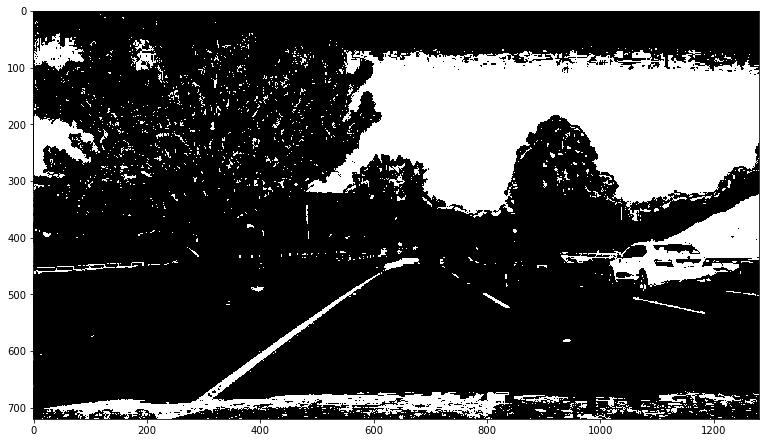

In [35]:
# ( (h_binary & s_binary) | (s_binary & v_binary) ) & l_binary
hbsvl_thresh = np.zeros_like(colour_threshold_imgs[0][0])
hbsvl_thresh[(hbsv_thresh == 1) & (colour_threshold_imgs[5][1] == 1)] = 1
plt.figure(figsize=(13,13))
plt.imshow(hbsvl_thresh*255, cmap='gray')

masked_edges shape:  (720, 1280)


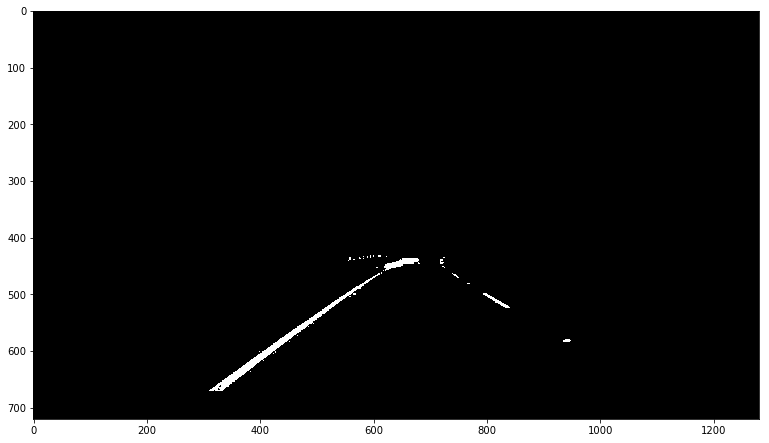

In [36]:
masked_img6 = region_of_interest(hbsvl_thresh, vertices_1, vertices_2)
plt.figure(figsize=(13,13))
plt.imshow(masked_img6, cmap='gray')

print("masked_edges shape: ", masked_img6.shape)

### Gradient Threshold

In [26]:
# Apply Sobel x or y, then takes an absolute value and applies a threshold.
# A function that takes an image, gradient orientation, and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output


# Applies Sobel x and y, then computes the magnitude of the gradient
# and applies a threshold.
# A function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


# Applies Sobel x and y, then computes the direction of the gradient
# and applies a threshold.
# A function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    #binary_output =  np.ones_like(absgraddir)
    #binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 0

    # Return the binary image
    return binary_output

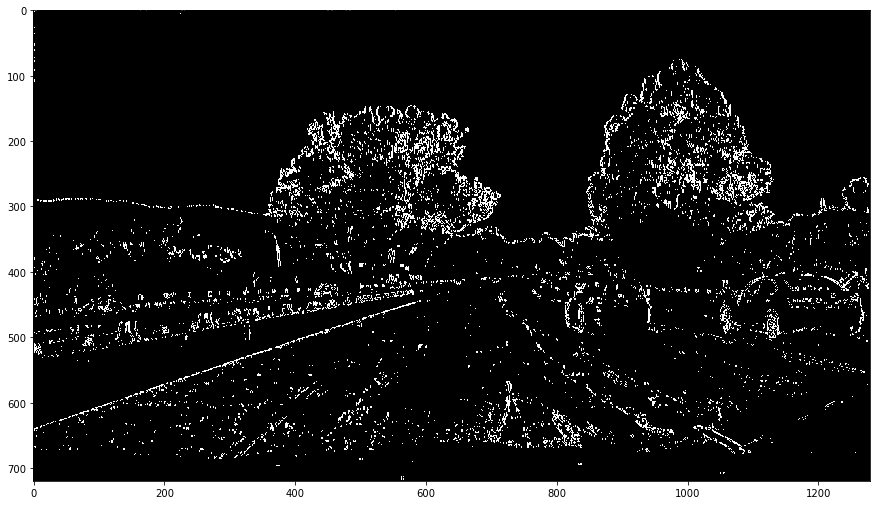

In [12]:
abs_x = abs_sobel_thresh(enhanced_imgs[0], orient='x', thresh_min=25, thresh_max=100)
plt.figure(figsize=(15, 15))
plt.imshow(abs_x, cmap='gray')

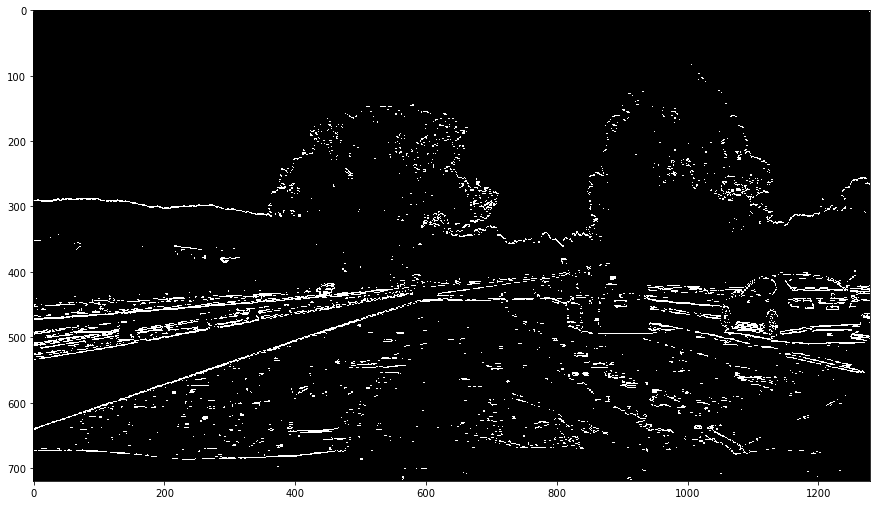

In [13]:
abs_y = abs_sobel_thresh(enhanced_imgs[0], orient='y', thresh_min=50, thresh_max=150)
plt.figure(figsize=(15, 15))
plt.imshow(abs_y, cmap='gray')

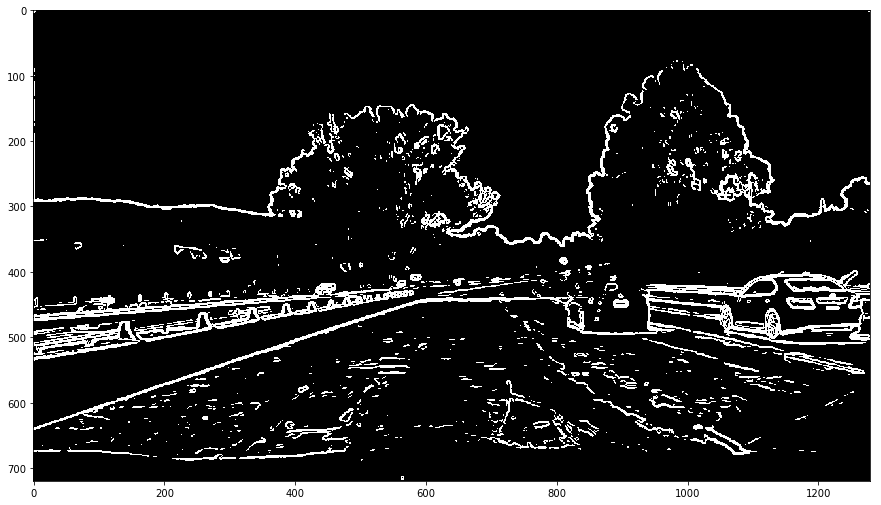

In [14]:
mag_grad = mag_thresh(enhanced_imgs[0], sobel_kernel=9, mag_thresh=(50, 250))
plt.figure(figsize=(15, 15))
plt.imshow(mag_grad, cmap='gray')

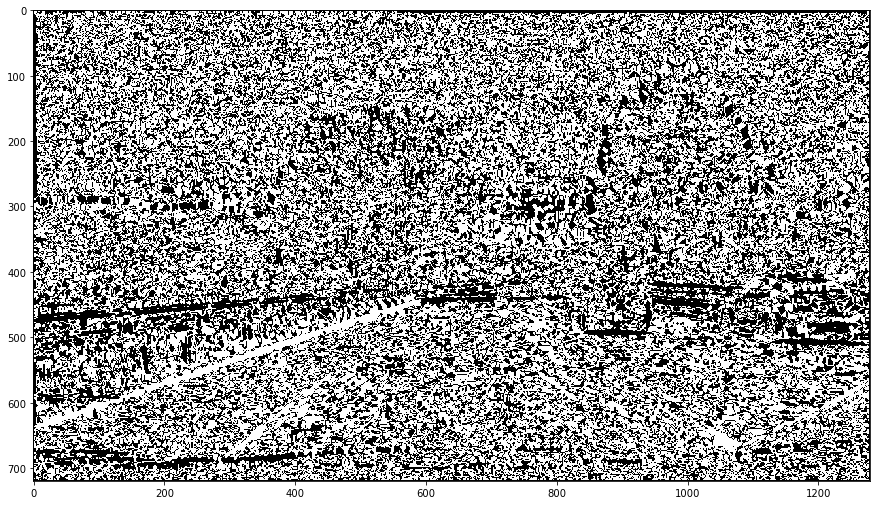

In [85]:
#dir_grad = dir_threshold(enhanced_img, sobel_kernel=15, thresh=(0.7, 1.3))
dir_grad = dir_threshold(enhanced_imgs[0], sobel_kernel=15, thresh=(30*np.pi/180, 80*np.pi/180))
plt.figure(figsize=(15, 15))
plt.imshow(dir_grad, cmap='gray')

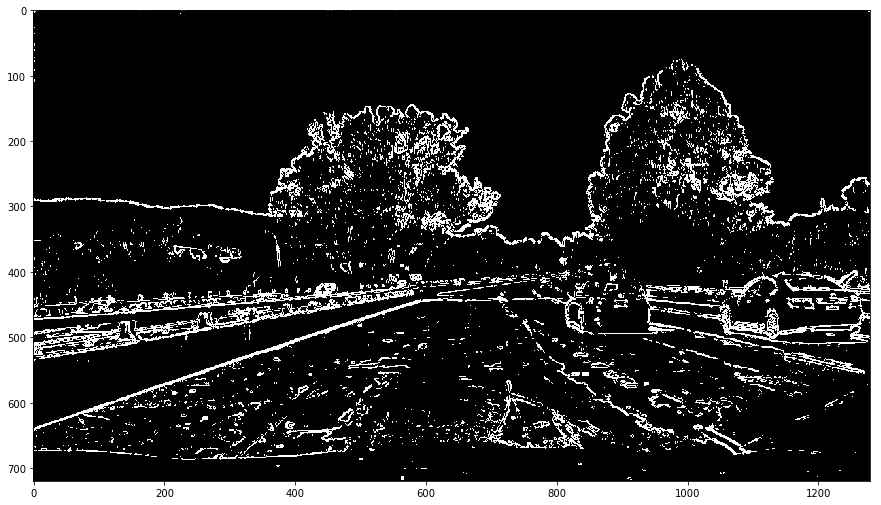

In [86]:
grad_filter = np.zeros_like(enhanced_imgs[0][:,:,0])
#grad_filter[(abs_x == 1) | (abs_y == 1) ] = 1
grad_filter[(abs_x == 1) | (abs_y == 1) | ((mag_grad == 1)) & (dir_grad == 1)] = 1
plt.figure(figsize=(15, 15))
plt.imshow(grad_filter * 255, cmap='gray')

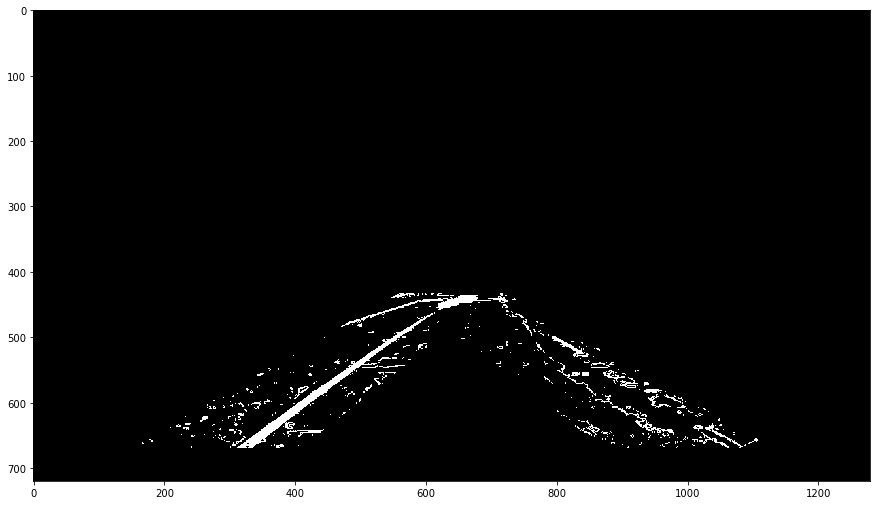

In [55]:
fff = np.zeros_like(enhanced_imgs[0][:,:,0])
fff[( region_of_interest(grad_filter, vertices_1, vertices_2) == 1) | ( masked_img6 == 1)] = 1
plt.figure(figsize=(15, 15))
plt.imshow(fff * 255, cmap='gray')

# Perspective Transform

[[ 150  684]
 [ 520  446]
 [ 760  446]
 [1130  684]]


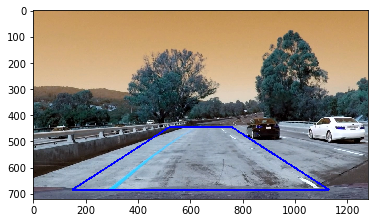

In [43]:
img = np.copy(cv2.imread('./test_images/test1.jpg'))
#img = np.copy(masked_img6)
imshape = np.shape(img)#(img.shape[1], img.shape[0])
# work on defining perspective transformation area
src_bottom_mask = 490
src_middle_mask = 120
src_width_center = imshape[1]*0.5
src_middle_height = imshape[0]*0.62
src_bottom_height = imshape[0]*0.95

src = np.array([(src_width_center-src_bottom_mask, src_bottom_height),
                (src_width_center-src_middle_mask, src_middle_height),
                (src_width_center+src_middle_mask, src_middle_height),
                (src_width_center+src_bottom_mask, src_bottom_height)], dtype=np.int32)
print(src)
cv2.polylines(img, [src], True, (0,0,255), thickness=5)

plt.imshow(img)
#plt.imshow(perspective_img)

[[540 684]
 [440   0]
 [840   0]
 [740 684]]


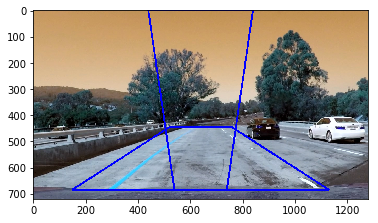

In [44]:
img2 = np.copy(img)

dst_bottom_mask = 100
dst_middle_mask = 200
dst_width_center = imshape[1]*0.5
dst_middle_height = imshape[0]*0
dst_bottom_height = imshape[0]*0.95

dst = np.array([ (dst_width_center-dst_bottom_mask, dst_bottom_height), 
                (dst_width_center-dst_middle_mask, dst_middle_height),
                (dst_width_center+dst_middle_mask, dst_middle_height),
                (dst_width_center+dst_bottom_mask, dst_bottom_height)], dtype=np.int32)
print(dst)
cv2.polylines(img2, [dst], True, (0,0,255), thickness=5)

plt.imshow(img2)

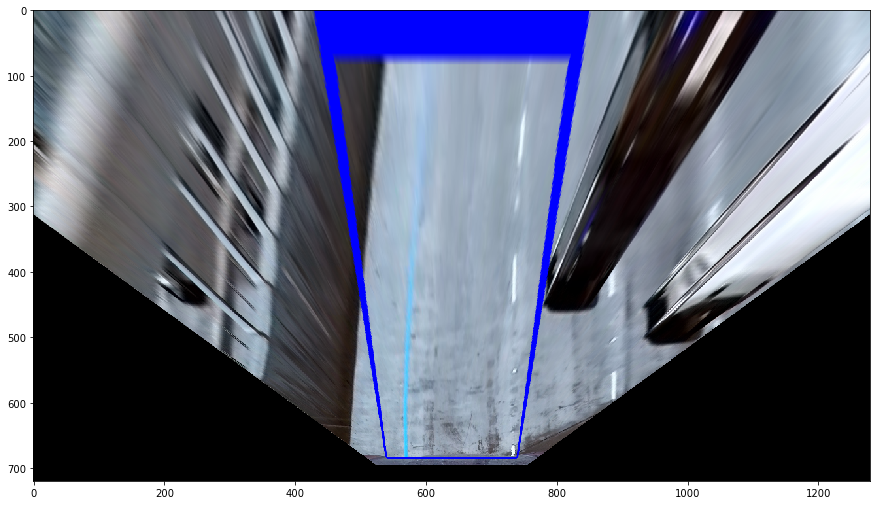

In [51]:
# perform the transform
img_size = (img.shape[1], img.shape[0])
M = cv2.getPerspectiveTransform(src.astype(np.float32), dst.astype(np.float32))
Minv = cv2.getPerspectiveTransform(dst.astype(np.float32),src.astype(np.float32))
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

plt.figure(figsize=(15,15))
plt.imshow(warped)

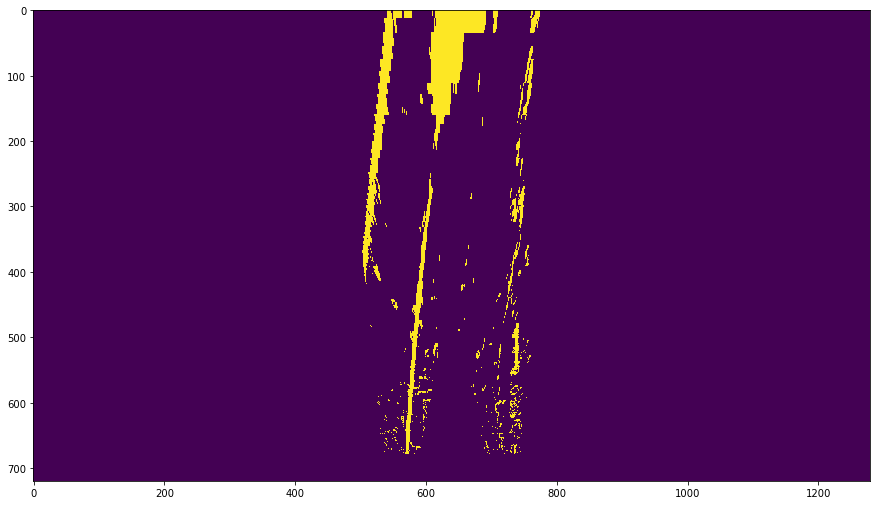

In [56]:
def perspective_transform(image_data):
    img = np.copy(image_data)
    imshape = np.shape(img)
    img_size = (img.shape[1], img.shape[0])

    # work on defining perspective transformation area    
    src_bottom_mask = 490
    src_middle_mask = 120
    src_width_center = imshape[1]*0.5
    src_middle_height = imshape[0]*0.62
    src_bottom_height = imshape[0]*0.95
    
    src = np.array([(src_width_center-src_bottom_mask, src_bottom_height),
                    (src_width_center-src_middle_mask, src_middle_height),
                    (src_width_center+src_middle_mask, src_middle_height),
                    (src_width_center+src_bottom_mask, src_bottom_height)], dtype=np.int32)

    # work on defining transformation area
    dst_bottom_mask = 100
    dst_middle_mask = 200
    dst_width_center = imshape[1]*0.5
    dst_middle_height = imshape[0]*0
    dst_bottom_height = imshape[0]*0.95

    dst = np.array([ (dst_width_center-dst_bottom_mask, dst_bottom_height), 
                    (dst_width_center-dst_middle_mask, dst_middle_height),
                    (dst_width_center+dst_middle_mask, dst_middle_height),
                    (dst_width_center+dst_bottom_mask, dst_bottom_height)], dtype=np.int32)
    
    # perform the transform
    M = cv2.getPerspectiveTransform(src.astype(np.float32), dst.astype(np.float32))
    Minv = cv2.getPerspectiveTransform(dst.astype(np.float32),src.astype(np.float32))
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M, Minv

test_img = cv2.imread('./test_images/test1.jpg')
transformed_img, M, Minv = perspective_transform(fff)
plt.figure(figsize=(15,15))
plt.imshow(transformed_img)

# Tracking

(720, 0)

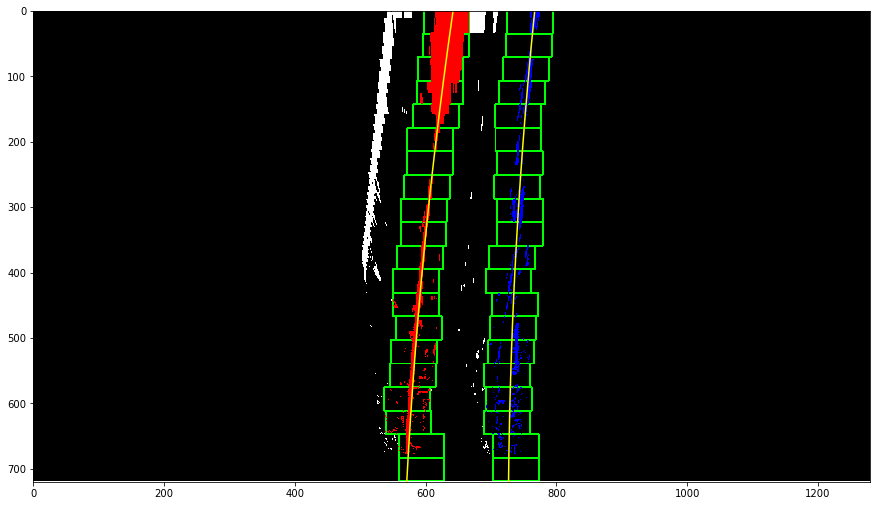

In [57]:
def sliding_windows_and_poly_fit(transformed_image, num_windows=9, margin = 100):
    binary_warped = np.copy(transformed_image)
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = num_windows
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    #margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Create an image to draw on and an image to show the selection window
    poly_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    poly_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    poly_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin+40, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin-40, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin+40, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin-40, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(poly_img, 1, window_img, 0.3, 0)
    
    return out_img, left_fitx, right_fitx, ploty, result

fit_img, left_fit_x, right_fit_x, fit_y, polygon_window = sliding_windows_and_poly_fit(transformed_img, num_windows=20, margin = 35)

plt.figure(figsize=(15, 15))
plt.imshow(fit_img)
plt.plot(left_fit_x, fit_y, color='yellow')
plt.plot(right_fit_x, fit_y, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [ ]:
plt.figure(figsize=(15, 15))
plt.imshow(polygon_window)

In [ ]:
road_warped = cv2.warpPerspective(polygon_window, Minv, (polygon_window.shape[1], polygon_window.shape[0]), flags=cv2.INTER_LINEAR)
result = cv2.addWeighted(undistortion_img, 1, road_warped, 0.3, 0)
plt.figure(figsize=(15, 15))
plt.imshow(result)

In [ ]:
y_eval = np.max(fit_y)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(fit_y*ym_per_pix, left_fit_x*xm_per_pix, 2)
right_fit_cr = np.polyfit(fit_y*ym_per_pix, right_fit_x*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m